In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../kaisr/

/home/remedios/kaisr/kaisr


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from skimage.metrics import peak_signal_noise_ratio


from pathlib import Path
import nibabel as nib

from utils.plot import *
from utils.train_loader_1D_FB import TrainSet as TrainSet1D
from utils.train_loader_1D_FB import normalize
from utils.train_loader_patches import TrainSet as TrainSetPatches
from utils.filter_bank_utils import *
from utils.degrade import *
from tqdm import tqdm

def fourier_mag(x):
    return np.abs(np.fft.fftshift(np.fft.fft(x)))

set_display_mode('dark')
device = device = torch.device(f'cuda:1')

In [4]:
fwhm = 4
gap = 1
M = fwhm + gap

In [5]:
# lr_fpath = Path("/home/remedios/data/old/OASIS3/OASIS3_04x_aniso/sub-OAS30003_ses-d0558_run-01_T1w.nii.gz")
lr_fpath = Path(f"/home/remedios/data/old/OASIS3/OASIS3_{fwhm:02d}x_{gap:02d}gap_aniso/sub-OAS30003_ses-d0558_run-01_T1w.nii.gz")
lr_vol = nib.load(lr_fpath).get_fdata(dtype=np.float32)

gt_fpath = Path("/home/remedios/data/old/OASIS3/OASIS3_iso/sub-OAS30003_ses-d0558_run-01_T1w.nii.gz")
gt_vol = nib.load(gt_fpath).get_fdata(dtype=np.float32)

lr_vol = np.pad(lr_vol, (((256-176)//2, (256-176)//2), (0, 0), (0, 0)))
gt_vol = np.pad(gt_vol, (((256-176)//2, (256-176)//2), (0, 0), (0, 0)))

In [6]:
slice_profile_fpath = Path("../results/filters/06x_02gap_OAS30003/result.npy")

In [7]:
lr_vol.shape

(256, 256, 52)

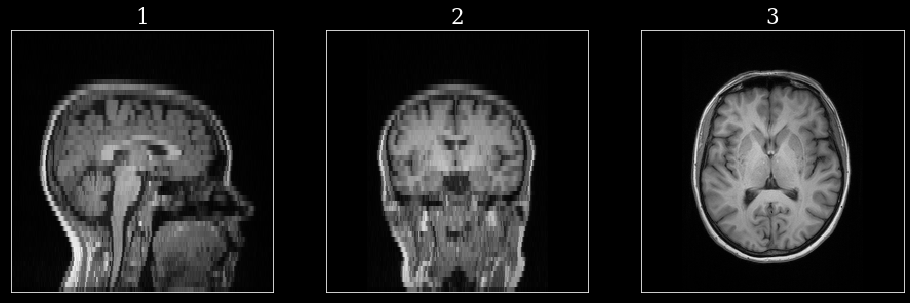

In [8]:
center_vol_plot(lr_vol, target_shape=(256, 256, 256))

# Try to design PR filters given fixed $M$ and $h_0$

In [9]:
colors = plt.cm.rainbow(np.linspace(0, 1, M))

In [10]:
# First, ensure filterless FB gives PR
p = 32
x = lr_vol[:, :, lr_vol.shape[2]//2]
x = np.pad(x, ((0, 0), (p, p)), mode='reflect')
x = torch.from_numpy(x).to(device)

x_hat = synthesize(analyze(x, hs=[None]*M, filterless=True), fs=[None]*M, filterless=True)

x = x[:, p:-p]
x_hat = x_hat[:, p:-p]

In [11]:
x = x.detach().cpu().numpy()
x_hat = x_hat.detach().cpu().numpy()

diff = np.log(np.abs(x - x_hat) + 1e-8)

In [12]:
data_range = x.max() - x.min()
psnr = peak_signal_noise_ratio(x, x_hat, data_range=data_range)

/home/remedios/miniconda3/envs/kaisr/lib/python3.9/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


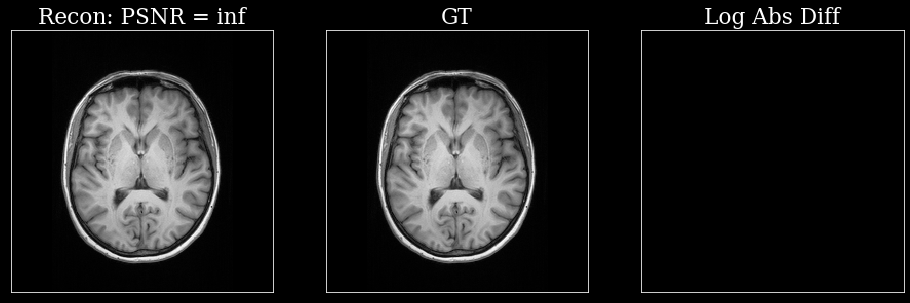

In [13]:
multiplot([x_hat, x, diff], [f'Recon: PSNR = {psnr:.2f}', 'GT', 'Log Abs Diff'])

In [14]:
h0 = torch.from_numpy(np.load(slice_profile_fpath)).to(device)

In [15]:
def modulate(h0, k, M, is_analysis=True):
    n = torch.linspace(0, len(h0)-1, len(h0), device=device)
    C = np.sqrt(2 / M)
    mod = C * torch.cos((k + 1/2) * (n  + (M + 1) / 2) * (torch.pi / M))
    
#     N = len(h0)
#     C = 2
#     if is_analysis:
#         mod = C * torch.cos((2 * k + 1) * (torch.pi / (2 * M)) * (n - (N - 1) / 2) + (-1)**k * torch.pi / 4)
#     else:
#         mod = C * torch.cos((2 * k + 1) * (torch.pi / (2 * M)) * (n - (N - 1) / 2) - (-1)**k * torch.pi / 4)
    return h0 * mod

In [16]:
hs = [h0]
for k in range(1, M):
    h_k = modulate(h0, k, M)
#     h_k /= torch.norm(h_k, p=2)
    hs.append(h_k)
hs = [h.detach().cpu().numpy() for h in hs]

# fs = []
# for k in range(0, 4):
#     f_k = modulate(h0, k, 4, is_analysis=False)
# #     h_k /= torch.norm(h_k, p=2)
#     fs.append(f_k)
# fs = [f.detach().cpu().numpy() for f in fs]
fs = [h[::-1] for h in hs]

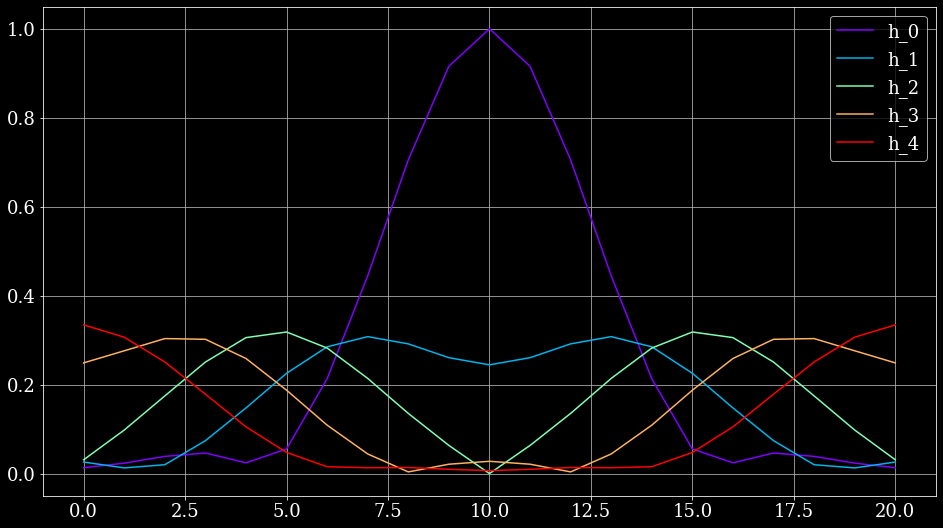

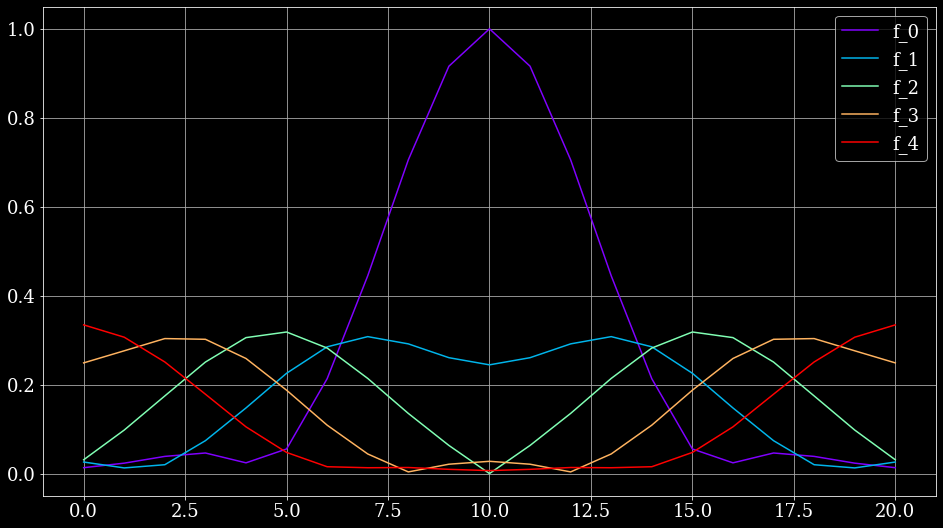

In [17]:
for i, (h, color) in enumerate(zip(hs, colors)):
    plt.plot(fourier_mag(h), color=color, label=f'h_{i}')
#     plt.plot(h, color=color, label=f'h_{i}')
plt.grid()
plt.legend()
plt.show()

for i, (f, color) in enumerate(zip(fs, colors)):
    plt.plot(fourier_mag(f), color=color, label=f'f_{i}')
#     plt.plot(h, color=color, label=f'h_{i}')
plt.grid()
plt.legend()
plt.show()

In [18]:
hs = [torch.from_numpy(h.copy()).to(device) for h in hs]
fs = [torch.from_numpy(f.copy()).to(device) for f in fs]

In [19]:
p = 32
x = lr_vol[:, :, lr_vol.shape[2]//2]
x = np.pad(x, ((0, 0), (p, p)), mode='reflect')
x = torch.from_numpy(x).to(device)

x_hat = synthesize(analyze(x, hs=hs), fs=fs)

x = x[:, p:-p]
x_hat = x_hat[:, p:-p]

In [20]:
x = x.detach().cpu().numpy()
x_hat = x_hat.detach().cpu().numpy()

diff = np.abs(x - x_hat)

In [21]:
data_range = x.max() - x.min()
psnr = peak_signal_noise_ratio(x, x_hat, data_range=data_range)

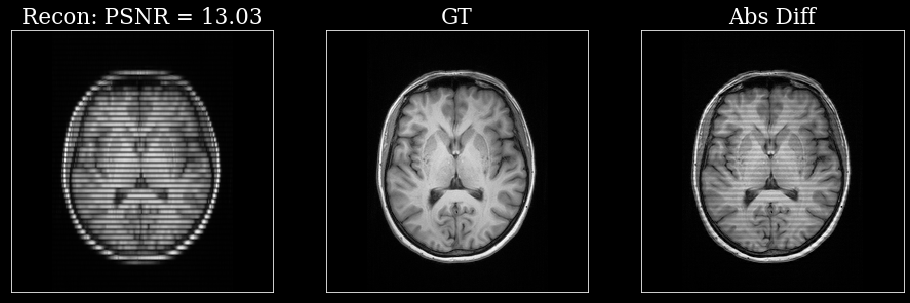

In [22]:
multiplot([x_hat, x, diff], [f'Recon: PSNR = {psnr:.2f}', 'GT', 'Abs Diff'])

# Stage 1: Learn the filters

In [23]:
hs = [h.detach().cpu().numpy() for h in hs]

In [24]:
# Load up data
batch_size = 2**6
n_items = 50000 * batch_size

ds_stage_1 = TrainSet1D(vol_fpath=lr_fpath, lr_dim=2, M=M, n_items=n_items)
loader_stage_1 = DataLoader(
    ds_stage_1,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=8,
)

In [25]:
class Network(nn.Module):
    def __init__(self, init_codes, features, device):
        super().__init__()
        
        self.L = len(init_codes[0])
        M = len(init_codes)
        
        # initial latent codes
        init_codes = [torch.from_numpy(init_code).to(device)
                      for init_code in init_codes]
        
        self.latent_codes = [torch.zeros_like(init_code, requires_grad=True, device=device)
                             for init_code in init_codes]
        for i in range(M):
            self.latent_codes[i].data = init_codes[i].data
        
        self.nets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.L, features),
                nn.LeakyReLU(inplace=True),
                nn.Linear(features, features),
                nn.LeakyReLU(inplace=True),
                nn.Linear(features, self.L),
            ) for _ in range(M)])
        
#     def _zero_out_dc(self, x):
#         x = torch.fft.fft(x)
#         x[0] = 0
#         return torch.abs(torch.fft.ifft(x))
        

    def forward(self):
        filters = [x for x in self.latent_codes]
    
#         filters = [net(latent_code)
#                    for net, latent_code in zip(self.nets, self.latent_codes)]
        # constraint: DC is zero
#         filters = [self._zero_out_dc(filt) for filt in filters]
        
        # normalize to unit energy
#         filters = [f / torch.abs(f).sum() for f in filters]
        return filters

In [26]:
init_codes = hs * 2
init_codes = init_codes[1:] # discard first filter; we're given h0
init_codes = [init_code.astype(np.float32) for init_code in init_codes]

In [27]:
G = Network(init_codes=init_codes, features=len(init_codes[0])*256, device=device).to(device)

In [28]:
lr = 1e-1
opt = torch.optim.AdamW(G.latent_codes, lr=lr)
# opt = torch.optim.AdamW(G.latent_codes + list(G.parameters()), lr=lr)

loss_fn = torch.nn.MSELoss().to(device)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=opt,
    max_lr=lr,
    total_steps=n_items+1,
    cycle_momentum=True,
)

# scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer=opt,
#     step_size=n_items,
#     gamma=0.1,
# )
opt.step()

In [29]:
with tqdm(total=n_items) as pbar:
    pbar_dict = {
        'loss': np.finfo(np.float32).max,
    }
    for cur_batch, xs_cpu in enumerate(loader_stage_1):
        opt.zero_grad()

        xs = xs_cpu.to(device)

        filters = G()
        hs = [h0, *filters[:M-1]]
        fs = filters[M-1:]

        coefs = analyze(xs, hs)
        xs_hat = synthesize(coefs, fs)

        loss = loss_fn(xs_hat, xs)
        loss.backward()
        opt.step()

        if cur_batch % 5 == 0:
            pbar_dict['loss'] = loss.detach().cpu().numpy().item()
            pbar.set_postfix({k: f'{v:.6f}' for k, v in pbar_dict.items() if v != 0})
                
        scheduler.step()
        pbar.update(batch_size)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 3200000/3200000 [04:00<00:00, 13287.59it/s, loss=0.000012]


# Evaluate reconstruction

In [64]:
x = torch.from_numpy(lr_vol[:, :, lr_vol.shape[2]//2]).to(device)
x, *_ = normalize(x)

In [65]:
filters = G()
hs = [h0, *filters[:M-1]]
fs = filters[M-1:]

# hs = torch.from_numpy(np.array(hs, dtype=np.float32)).to(device)
# fs = [torch.flip(hs[0], dims=(0,)) for h in hs]

# hs = torch.from_numpy(np.array(hs, dtype=np.float32)).to(device)
# fs = torch.from_numpy(np.array(fs, dtype=np.float32)).to(device)

In [66]:
coefs = analyze(x, hs)
x_hat = synthesize(coefs, fs)

x = x.detach().cpu().numpy()
x_hat = x_hat.detach().cpu().numpy()

x_hat[x_hat < x.min()] = x.min()
x_hat[x_hat > x.max()] = x.max()

In [67]:
x_hat.shape, x.shape

((256, 260), (256, 256))

In [68]:
x_hat = x_hat[:, :-4]

In [69]:
data_range = x.max() - x.min()
psnr = peak_signal_noise_ratio(x, x_hat, data_range=data_range)

In [70]:
from datetime import datetime
dt_string = datetime.now().strftime("%Y%m%d_%H%M%S")
weight_dir = Path(f"./weights/filter_bank_{dt_string}")
if not weight_dir.exists():
    weight_dir.mkdir(parents=True)

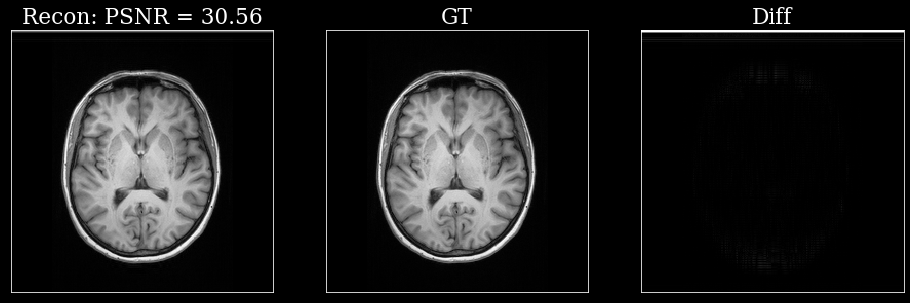

In [71]:
multiplot(
    [x_hat, x, np.abs(x_hat - x)], 
    [f'Recon: PSNR = {psnr:.2f}', 'GT', 'Diff'], 
    out_fpath=weight_dir / "recon_psnr.png",
)

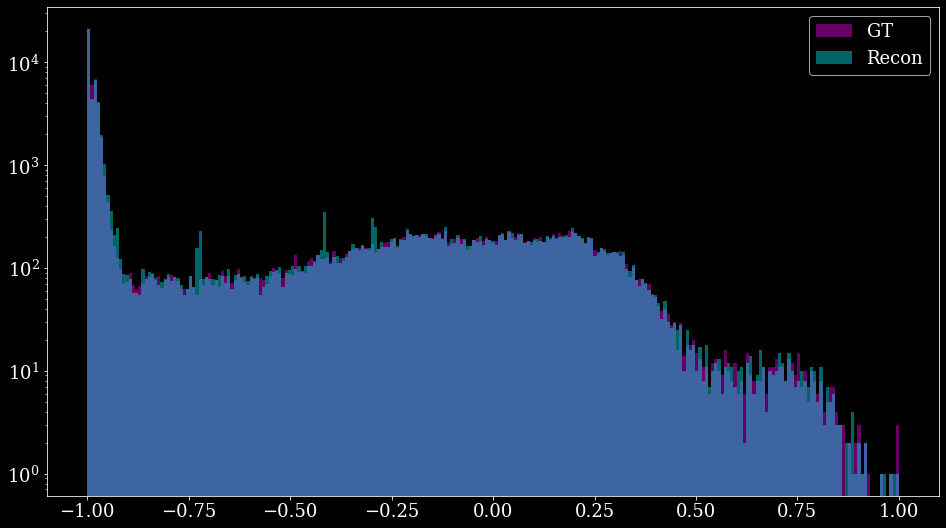

In [38]:
n_bins = 256
bins = np.round(np.linspace(
        min(x.min(), x_hat.min()),
        max(x.max(), x_hat.max()), 
        n_bins), 4)

plt.hist(x.flatten(), bins=bins, label='GT', color='magenta', alpha=0.4)
plt.hist(x_hat.flatten(), bins=bins, label='Recon', color='cyan', alpha=0.4)
plt.yscale('log')
plt.legend()
plt.show()

In [39]:
for filters, title in zip([hs, fs], ["Analysis Filters", "Synthesis Filters"]):
    if title == "Analysis Filters":
        label = 'h'
    else:
        label = 'f'
        
    for i, (filt, color) in enumerate(zip(filters, colors)):
        FILT = fourier_mag(filt.detach().cpu().numpy())

        plt.plot(FILT, label=f'{label}_{i}', color=color)

    plt.title(title)
    plt.grid()
    plt.legend()
    plt.xticks(ticks=range(len(filt)), labels=list(range(-len(filt)//2+1, len(filt)//2+1)))
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.savefig(weight_dir / (title.replace(" ", "_")+"_freq.png"))
    plt.show()

In [40]:
for filters, title in zip([hs, fs], ["Analysis Filters", "Synthesis Filters"]):
    if title == "Analysis Filters":
        label = 'h'
    else:
        label = 'f'
        
    for i, (filt, color) in enumerate(zip(filters, colors)):
        plt.plot(filt.detach().cpu().numpy(), label=f'{label}_{i}', color=color)

    plt.title(title)
    plt.grid()
    plt.legend()
    plt.xticks(ticks=range(len(filt)), labels=list(range(-len(filt)//2+1, len(filt)//2+1)))
    plt.xlabel('Space')
    plt.ylabel('Amplitude')
    plt.savefig(weight_dir / (title.replace(" ", "_")+"_time.png"))
    plt.show()

In [41]:
torch.save([h.detach().cpu() for h in hs], weight_dir / "hs.pt")
torch.save([f.detach().cpu() for f in fs], weight_dir / "fs.pt")

In [42]:
weight_dir

PosixPath('weights/filter_bank_20220217_111258')

# With randomly generated filters...

In [43]:
x = torch.from_numpy(lr_vol[:, :, lr_vol.shape[2]//2]).to(device)
x, *_ = normalize(x)

In [44]:
hs_k = torch.randn((3, 21)).to(device)
fs = torch.randn((4, 21)).to(device)

# normalize l2 norm
for i in range(len(hs_k)):
    hs_k[i] /= torch.norm(hs_k[i], p=2)
    
for i in range(len(fs)):
    fs[i] /= torch.norm(fs[i], p=2)

In [45]:
hs = [h0, *hs_k]


# hs = torch.from_numpy(np.array(hs, dtype=np.float32)).to(device)
# fs = [torch.flip(hs[0], dims=(0,)) for h in hs]

# hs = torch.from_numpy(np.array(hs, dtype=np.float32)).to(device)
# fs = torch.from_numpy(np.array(fs, dtype=np.float32)).to(device)

In [46]:
hs[1].shape

torch.Size([21])

In [47]:
hs = torch.from_numpy(np.array([h.detach().cpu().numpy() for h in hs])).to(device)

In [48]:
fs = torch.pinverse(hs).T.to(device)

In [49]:
coefs = analyze(x, hs)
x_hat = synthesize(coefs, fs)

x = x.detach().cpu().numpy()
x_hat = x_hat.detach().cpu().numpy()

x_hat[x_hat < x.min()] = x.min()
x_hat[x_hat > x.max()] = x.max()

In [50]:
data_range = x.max() - x.min()
psnr = peak_signal_noise_ratio(x, x_hat, data_range=data_range)

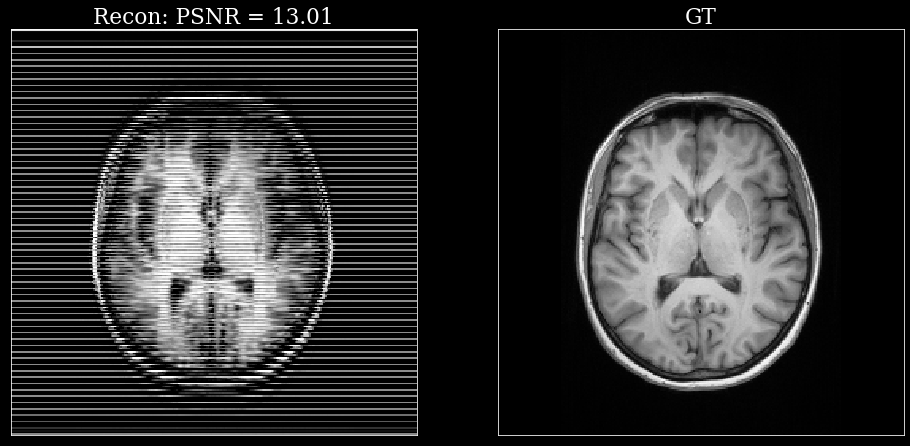

In [51]:
multiplot(
    [x_hat, x], 
    [f'Recon: PSNR = {psnr:.2f}', 'GT'], 
    out_fpath=weight_dir / "recon_psnr.png",
)

# Compare to TDLT

In [52]:
hs = np.array([
  [-0.076640741219094,   0.114700974963451,   0.385299025036549,   0.576640741219094,   0.576640741219094,   0.385299025036549,   0.114700974963451,  -0.076640741219094,],
  [-0.114700974963451,   0.076640741219094,   0.576640741219094,   0.385299025036549,  -0.385299025036549,  -0.576640741219094,  -0.076640741219094,   0.114700974963451,],
  [-0.114700974963451,  -0.076640741219094,   0.576640741219094,  -0.385299025036549,  -0.385299025036549,   0.576640741219094,  -0.076640741219094,  -0.114700974963451,],
  [-0.076640741219094,  -0.114700974963451,   0.385299025036549,  -0.576640741219094,   0.576640741219094,  -0.385299025036549,   0.114700974963451,   0.076640741219094,],
], dtype=np.float32)

In [53]:
fs = hs
# fs = hs[:, ::-1]

In [54]:
hs = torch.from_numpy(hs.copy()).to(device)
fs = torch.from_numpy(fs.copy()).to(device)

In [55]:
# hs /= np.abs(hs).sum()
# fs /= np.abs(fs).sum()

In [56]:
# plt.plot(hs[0], color=colors[0])
# plt.plot(hs[1], color=colors[1])
# plt.plot(hs[2], color=colors[2])
# plt.plot(hs[3], color=colors[3])

In [57]:
# plt.plot(fs[0], color=colors[0])
# plt.plot(fs[1], color=colors[1])
# plt.plot(fs[2], color=colors[2])
# plt.plot(fs[3], color=colors[3])

In [58]:
# M = 4
# colors = plt.cm.rainbow(np.linspace(0, 1, M))

In [59]:
# First, ensure filterless FB gives PR
p = 32
x = lr_vol[:, :, 32]
x = np.pad(x, ((0, 0), (p, p)), mode='reflect')
x = torch.from_numpy(x).to(device)

x_hat = synthesize(analyze(x, hs=hs, filterless=False), fs=fs, filterless=False)

x = x[:, p:-p]
x_hat = x_hat[:, p:-p]

/home/remedios/kaisr/kaisr/utils/filter_bank_utils.py:64: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  return F.conv1d(


In [60]:
x = x.detach().cpu().numpy()
x_hat = x_hat.detach().cpu().numpy()

x_hat[x_hat < x.min()] = x.min()
x_hat[x_hat > x.max()] = x.max()

diff = np.log(np.abs(x - x_hat) + 1e-8)

In [61]:
data_range = x.max() - x.min()
psnr = peak_signal_noise_ratio(x, x_hat, data_range=data_range)

In [62]:
multiplot([x_hat, x, diff], [f'Recon: PSNR = {psnr:.2f}', 'GT', 'Log Abs Diff'])

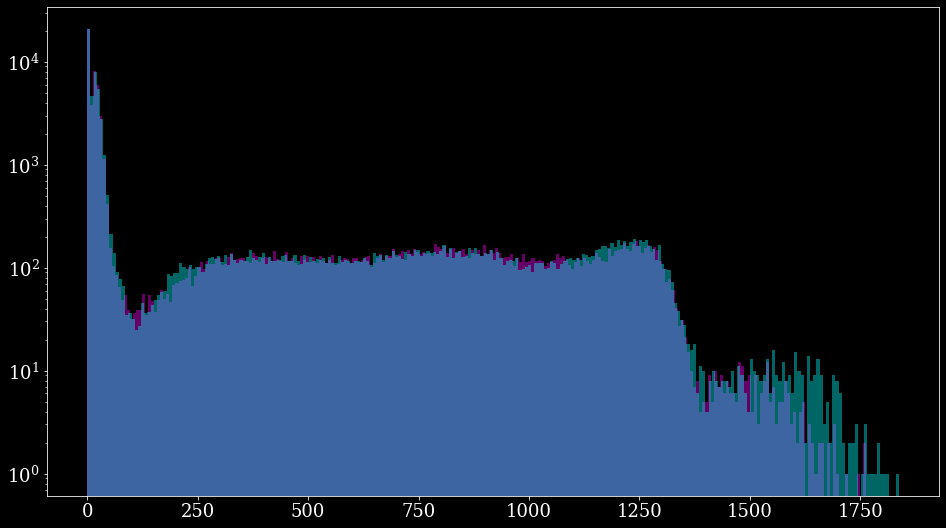

In [63]:
_ = plt.hist(x_hat.flatten(), bins=256, color='magenta', alpha=0.4)
_ = plt.hist(x.flatten(), bins=256, color='cyan', alpha=0.4)

plt.yscale('log')
plt.show()